# 🚴 Analyse Complète des Données VéloMAG Montpellier

## Objectif
Ce notebook permet de générer une analyse statistique complète du système de vélos en libre-service VéloMAG de Montpellier en utilisant les APIs officielles de la métropole.

## Données analysées
- **Données en temps réel** : État actuel de toutes les stations
- **Données historiques** : Séries temporelles de disponibilité des vélos
- **Analyses géographiques** : Répartition spatiale et cartes interactives
- **Patterns d'usage** : Tendances horaires, quotidiennes et saisonnières

## APIs utilisées
1. **API Stations** : `https://portail-api-data.montpellier3m.fr/bikestation`
2. **API Séries temporelles** : `https://portail-api-data.montpellier3m.fr/bikestation_timeseries/{station_id}/attrs/{attribute}`

---

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📚 SECTION 1: Import Required Libraries
# ═══════════════════════════════════════════════════════════════════════════════

import warnings
warnings.filterwarnings('ignore')

# APIs et requêtes HTTP
import requests
import urllib.parse
import json
import time

# Manipulation de données
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Cartes interactives
import folium
from folium import plugins

# Outils statistiques
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pyo.init_notebook_mode(connected=True)

# Configuration pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Toutes les bibliothèques ont été importées avec succès!")
print(f"📅 Analyse démarrée le {datetime.now().strftime('%d/%m/%Y à %H:%M:%S')}")

✅ Toutes les bibliothèques ont été importées avec succès!
📅 Analyse démarrée le 27/07/2025 à 18:55:10


In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🔧 SECTION 2: API Configuration and Helper Functions
# ═══════════════════════════════════════════════════════════════════════════════

# Configuration des APIs
API_BASE_URL = "https://portail-api-data.montpellier3m.fr"
STATIONS_ENDPOINT = "/bikestation"
TIMESERIES_ENDPOINT = "/bikestation_timeseries"

# Configuration globale
REQUEST_TIMEOUT = 30
RETRY_ATTEMPTS = 3
RATE_LIMIT_DELAY = 0.5

class VelomagAPI:
    """Classe pour interagir avec les APIs VéloMAG"""
    
    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'VelomagAnalyzer/1.0',
            'Accept': 'application/json'
        })
        
    def get_all_stations(self):
        """Récupère toutes les stations"""
        url = f"{API_BASE_URL}{STATIONS_ENDPOINT}"
        
        for attempt in range(RETRY_ATTEMPTS):
            try:
                response = self.session.get(url, timeout=REQUEST_TIMEOUT)
                response.raise_for_status()
                data = response.json()
                print(f"✅ {len(data)} stations récupérées avec succès")
                return data
            except requests.RequestException as e:
                print(f"⚠️ Tentative {attempt + 1}/{RETRY_ATTEMPTS} échouée: {e}")
                if attempt < RETRY_ATTEMPTS - 1:
                    time.sleep(RATE_LIMIT_DELAY * (attempt + 1))
                else:
                    print(f"❌ Impossible de récupérer les données après {RETRY_ATTEMPTS} tentatives")
                    return []
    
    def get_station_timeseries(self, station_id, attribute="availableBikeNumber", 
                              from_date=None, to_date=None):
        """Récupère les données temporelles d'une station"""
        if not from_date:
            from_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%dT%H:%M:%S")
        if not to_date:
            to_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
        
        # Encodage de l'ID de station
        encoded_station_id = urllib.parse.quote(station_id, safe='')
        url = f"{API_BASE_URL}{TIMESERIES_ENDPOINT}/{encoded_station_id}/attrs/{attribute}"
        
        params = {
            'fromDate': from_date,
            'toDate': to_date
        }
        
        for attempt in range(RETRY_ATTEMPTS):
            try:
                response = self.session.get(url, params=params, timeout=REQUEST_TIMEOUT)
                response.raise_for_status()
                data = response.json()
                print(f"✅ Données temporelles récupérées pour {station_id}: {len(data.get('values', []))} points")
                return data
            except requests.RequestException as e:
                print(f"⚠️ Erreur station {station_id}, tentative {attempt + 1}: {e}")
                if attempt < RETRY_ATTEMPTS - 1:
                    time.sleep(RATE_LIMIT_DELAY * (attempt + 1))
                else:
                    return {}

def parse_station_data(stations_raw):
    """Parse les données brutes des stations en DataFrame"""
    stations_list = []
    
    for station in stations_raw:
        try:
            station_info = {
                'id': station['id'],
                'address': station['address']['value']['streetAddress'],
                'locality': station['address']['value']['addressLocality'],
                'available_bikes': station['availableBikeNumber']['value'],
                'free_slots': station['freeSlotNumber']['value'],
                'total_slots': station['totalSlotNumber']['value'],
                'status': station['status']['value'],
                'latitude': station['location']['value']['coordinates'][1],
                'longitude': station['location']['value']['coordinates'][0],
                'last_update': station['availableBikeNumber']['metadata'].get('timestamp', {}).get('value', 'N/A')
            }
            
            # Calculs dérivés
            station_info['occupancy_rate'] = station_info['available_bikes'] / station_info['total_slots'] if station_info['total_slots'] > 0 else 0
            station_info['usage_rate'] = (station_info['total_slots'] - station_info['free_slots']) / station_info['total_slots'] if station_info['total_slots'] > 0 else 0
            
            stations_list.append(station_info)
        except Exception as e:
            print(f"⚠️ Erreur parsing station {station.get('id', 'unknown')}: {e}")
    
    return pd.DataFrame(stations_list)

# Initialisation de l'API
api = VelomagAPI()
print("🔧 Configuration des APIs terminée")
print(f"🌐 URL de base: {API_BASE_URL}")
print(f"⏱️ Timeout: {REQUEST_TIMEOUT}s")

🔧 Configuration des APIs terminée
🌐 URL de base: https://portail-api-data.montpellier3m.fr
⏱️ Timeout: 30s


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📊 SECTION 3: Data Collection from APIs
# ═══════════════════════════════════════════════════════════════════════════════

print("🚀 Début de la collecte des données...")
print("="*60)

# Récupération des données actuelles
print("📡 Récupération des données de stations en temps réel...")
stations_raw = api.get_all_stations()

if not stations_raw:
    print("❌ Impossible de récupérer les données. Arrêt du notebook.")
    raise Exception("Pas de données disponibles")

# Conversion en DataFrame
df_stations = parse_station_data(stations_raw)
print(f"✅ DataFrame créé avec {len(df_stations)} stations")

# Affichage des informations générales
print("\n📋 Informations générales:")
print(f"   🏢 Nombre total de stations: {len(df_stations)}")
print(f"   🚴 Vélos disponibles: {df_stations['available_bikes'].sum()}")
print(f"   🅿️ Places libres: {df_stations['free_slots'].sum()}")
print(f"   📍 Capacité totale: {df_stations['total_slots'].sum()}")
print(f"   ✅ Stations actives: {len(df_stations[df_stations['status'] == 'working'])}")

# Preview des données
print("\n🔍 Aperçu des données:")
display(df_stations.head())

print("\n📈 Statistiques descriptives:")
display(df_stations[['available_bikes', 'free_slots', 'total_slots', 'occupancy_rate']].describe())

🚀 Début de la collecte des données...
📡 Récupération des données de stations en temps réel...
✅ 20 stations récupérées avec succès
✅ DataFrame créé avec 20 stations

📋 Informations générales:
   🏢 Nombre total de stations: 20
   🚴 Vélos disponibles: 111
   🅿️ Places libres: 160
   📍 Capacité totale: 271
   ✅ Stations actives: 20

🔍 Aperçu des données:
✅ 20 stations récupérées avec succès
✅ DataFrame créé avec 20 stations

📋 Informations générales:
   🏢 Nombre total de stations: 20
   🚴 Vélos disponibles: 111
   🅿️ Places libres: 160
   📍 Capacité totale: 271
   ✅ Stations actives: 20

🔍 Aperçu des données:


,id,address,locality,available_bikes,free_slots,total_slots,status,latitude,longitude,last_update,occupancy_rate,usage_rate
0,urn:ngsi-ld:station:001,Rue Jules Ferry - Gare Saint-Roch,Montpellier,7,5,12,working,43.605366,3.881346,2025-07-27T18:55:19.000Z,0.583333,0.583333
1,urn:ngsi-ld:station:002,Comédie,Montpellier,4,16,20,working,43.608148,3.878778,2025-07-27T18:55:19.000Z,0.200000,0.200000
2,urn:ngsi-ld:station:004,Hôtel de Ville,Montpellier,6,10,16,working,43.599088,3.894866,2025-07-27T18:55:19.000Z,0.375000,0.375000
3,urn:ngsi-ld:station:005,Corum,Montpellier,10,2,12,working,43.613989,3.881600,2025-07-27T18:55:19.000Z,0.833333,0.833333
4,urn:ngsi-ld:station:006,Place Albert 1er - St Charles,Montpellier,5,22,27,working,43.616768,3.873375,2025-07-27T18:55:19.000Z,0.185185,0.185185



📈 Statistiques descriptives:


,available_bikes,free_slots,total_slots,occupancy_rate
count,20.00000,20.000000,20.000000,20.000000
mean,5.55000,8.000000,13.550000,0.417176
std,3.56112,5.088687,4.773557,0.266437
min,0.00000,0.000000,8.000000,0.000000
25%,2.75000,5.000000,11.000000,0.237500
50%,5.00000,7.000000,12.000000,0.427083
75%,7.50000,9.250000,16.000000,0.593750
max,12.00000,22.000000,27.000000,1.000000


📊 Calcul des statistiques de base...
📋 RAPPORT STATISTIQUE GÉNÉRAL
🏢 Réseau:
   • Total stations: 20
   • Stations actives: 20 (100.0%)
   • Stations inactives: 0

🚴 Flotte:
   • Vélos disponibles: 111
   • Capacité totale: 271
   • Taux d'occupation global: 41.7%

📊 Distribution des vélos:
   • Moyenne: 5.5
   • Médiane: 5.0
   • Écart-type: 3.6
   • Minimum: 0.0
   • Maximum: 12.0

🏆 Stations remarquables:
   • Plus occupée: Antigone centre (100.0%)
   • Moins occupée: Halles Castellane (0.0%)
   • Plus grande: Place Albert 1er - St Charles (27 places)
   • Plus petite: Foch (8 places)

⚠️ Alertes:
   • Stations vides: 2
   • Stations pleines: 1
   • Stations hors service: 0


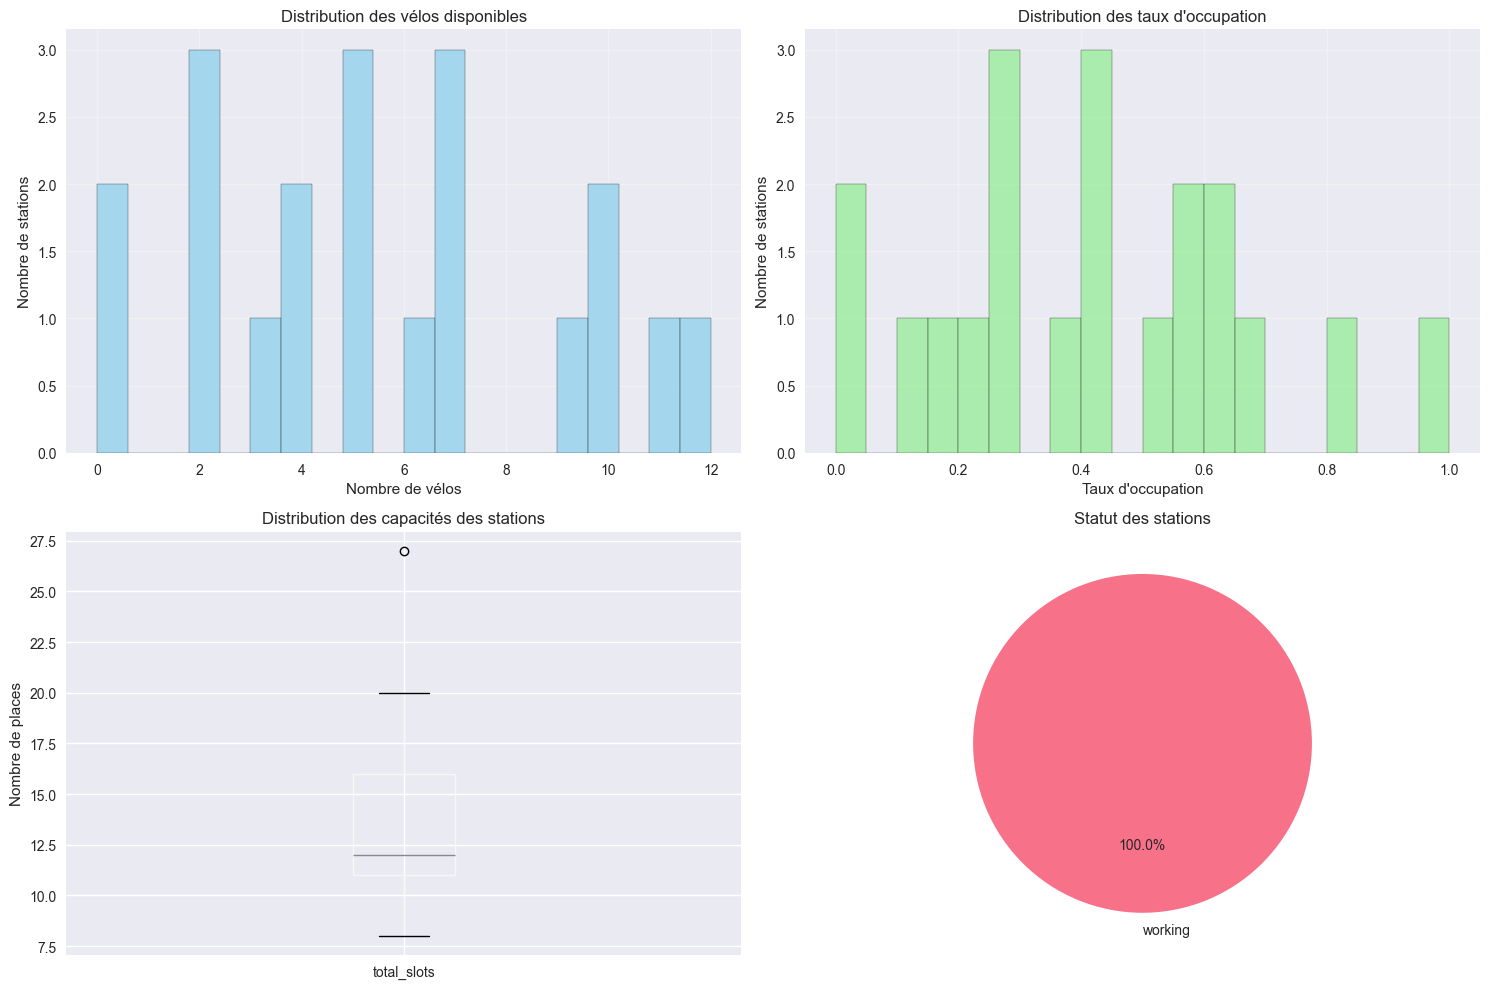

✅ Analyse statistique de base terminée


In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📊 SECTION 4: Basic Station Statistics
# ═══════════════════════════════════════════════════════════════════════════════

print("📊 Calcul des statistiques de base...")

# Métriques principales
total_stations = len(df_stations)
working_stations = len(df_stations[df_stations['status'] == 'working'])
total_bikes = df_stations['available_bikes'].sum()
total_capacity = df_stations['total_slots'].sum()
avg_occupancy = df_stations['occupancy_rate'].mean()

# Statistiques de distribution
bikes_stats = {
    'moyenne': df_stations['available_bikes'].mean(),
    'médiane': df_stations['available_bikes'].median(),
    'écart-type': df_stations['available_bikes'].std(),
    'minimum': df_stations['available_bikes'].min(),
    'maximum': df_stations['available_bikes'].max()
}

# Identification des stations extrêmes
most_occupied = df_stations.loc[df_stations['occupancy_rate'].idxmax()]
least_occupied = df_stations.loc[df_stations['occupancy_rate'].idxmin()]
largest_station = df_stations.loc[df_stations['total_slots'].idxmax()]
smallest_station = df_stations.loc[df_stations['total_slots'].idxmin()]

# Stations problématiques
empty_stations = df_stations[df_stations['available_bikes'] == 0]
full_stations = df_stations[df_stations['free_slots'] == 0]
inactive_stations = df_stations[df_stations['status'] != 'working']

print("="*60)
print("📋 RAPPORT STATISTIQUE GÉNÉRAL")
print("="*60)

print(f"🏢 Réseau:")
print(f"   • Total stations: {total_stations}")
print(f"   • Stations actives: {working_stations} ({working_stations/total_stations:.1%})")
print(f"   • Stations inactives: {len(inactive_stations)}")

print(f"\n🚴 Flotte:")
print(f"   • Vélos disponibles: {total_bikes}")
print(f"   • Capacité totale: {total_capacity}")
print(f"   • Taux d'occupation global: {avg_occupancy:.1%}")

print(f"\n📊 Distribution des vélos:")
for key, value in bikes_stats.items():
    print(f"   • {key.capitalize()}: {value:.1f}")

print(f"\n🏆 Stations remarquables:")
print(f"   • Plus occupée: {most_occupied['address']} ({most_occupied['occupancy_rate']:.1%})")
print(f"   • Moins occupée: {least_occupied['address']} ({least_occupied['occupancy_rate']:.1%})")
print(f"   • Plus grande: {largest_station['address']} ({largest_station['total_slots']} places)")
print(f"   • Plus petite: {smallest_station['address']} ({smallest_station['total_slots']} places)")

print(f"\n⚠️ Alertes:")
print(f"   • Stations vides: {len(empty_stations)}")
print(f"   • Stations pleines: {len(full_stations)}")
print(f"   • Stations hors service: {len(inactive_stations)}")

# Visualisation de la distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution des vélos disponibles
axes[0,0].hist(df_stations['available_bikes'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution des vélos disponibles')
axes[0,0].set_xlabel('Nombre de vélos')
axes[0,0].set_ylabel('Nombre de stations')
axes[0,0].grid(True, alpha=0.3)

# Distribution des taux d'occupation
axes[0,1].hist(df_stations['occupancy_rate'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Distribution des taux d\'occupation')
axes[0,1].set_xlabel('Taux d\'occupation')
axes[0,1].set_ylabel('Nombre de stations')
axes[0,1].grid(True, alpha=0.3)

# Boxplot des capacités
df_stations.boxplot(column='total_slots', ax=axes[1,0])
axes[1,0].set_title('Distribution des capacités des stations')
axes[1,0].set_ylabel('Nombre de places')

# Statut des stations
status_counts = df_stations['status'].value_counts()
axes[1,1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Statut des stations')

plt.tight_layout()
plt.show()

print("✅ Analyse statistique de base terminée")

⏰ Analyse des séries temporelles...
📅 Période analysée: 7 derniers jours
🏢 Échantillon: 5 stations
📡 Récupération données pour Rue Jules Ferry - Gare Saint-Roch...
✅ Données temporelles récupérées pour urn:ngsi-ld:station:001: 10000 points
✅ Données temporelles récupérées pour urn:ngsi-ld:station:001: 10000 points
📡 Récupération données pour Comédie...
📡 Récupération données pour Comédie...
✅ Données temporelles récupérées pour urn:ngsi-ld:station:002: 10000 points
✅ Données temporelles récupérées pour urn:ngsi-ld:station:002: 10000 points
📡 Récupération données pour Hôtel de Ville...
📡 Récupération données pour Hôtel de Ville...
✅ Données temporelles récupérées pour urn:ngsi-ld:station:004: 10000 points
✅ Données temporelles récupérées pour urn:ngsi-ld:station:004: 10000 points
📡 Récupération données pour Corum...
📡 Récupération données pour Corum...
✅ Données temporelles récupérées pour urn:ngsi-ld:station:005: 10000 points
✅ Données temporelles récupérées pour urn:ngsi-ld:station:00

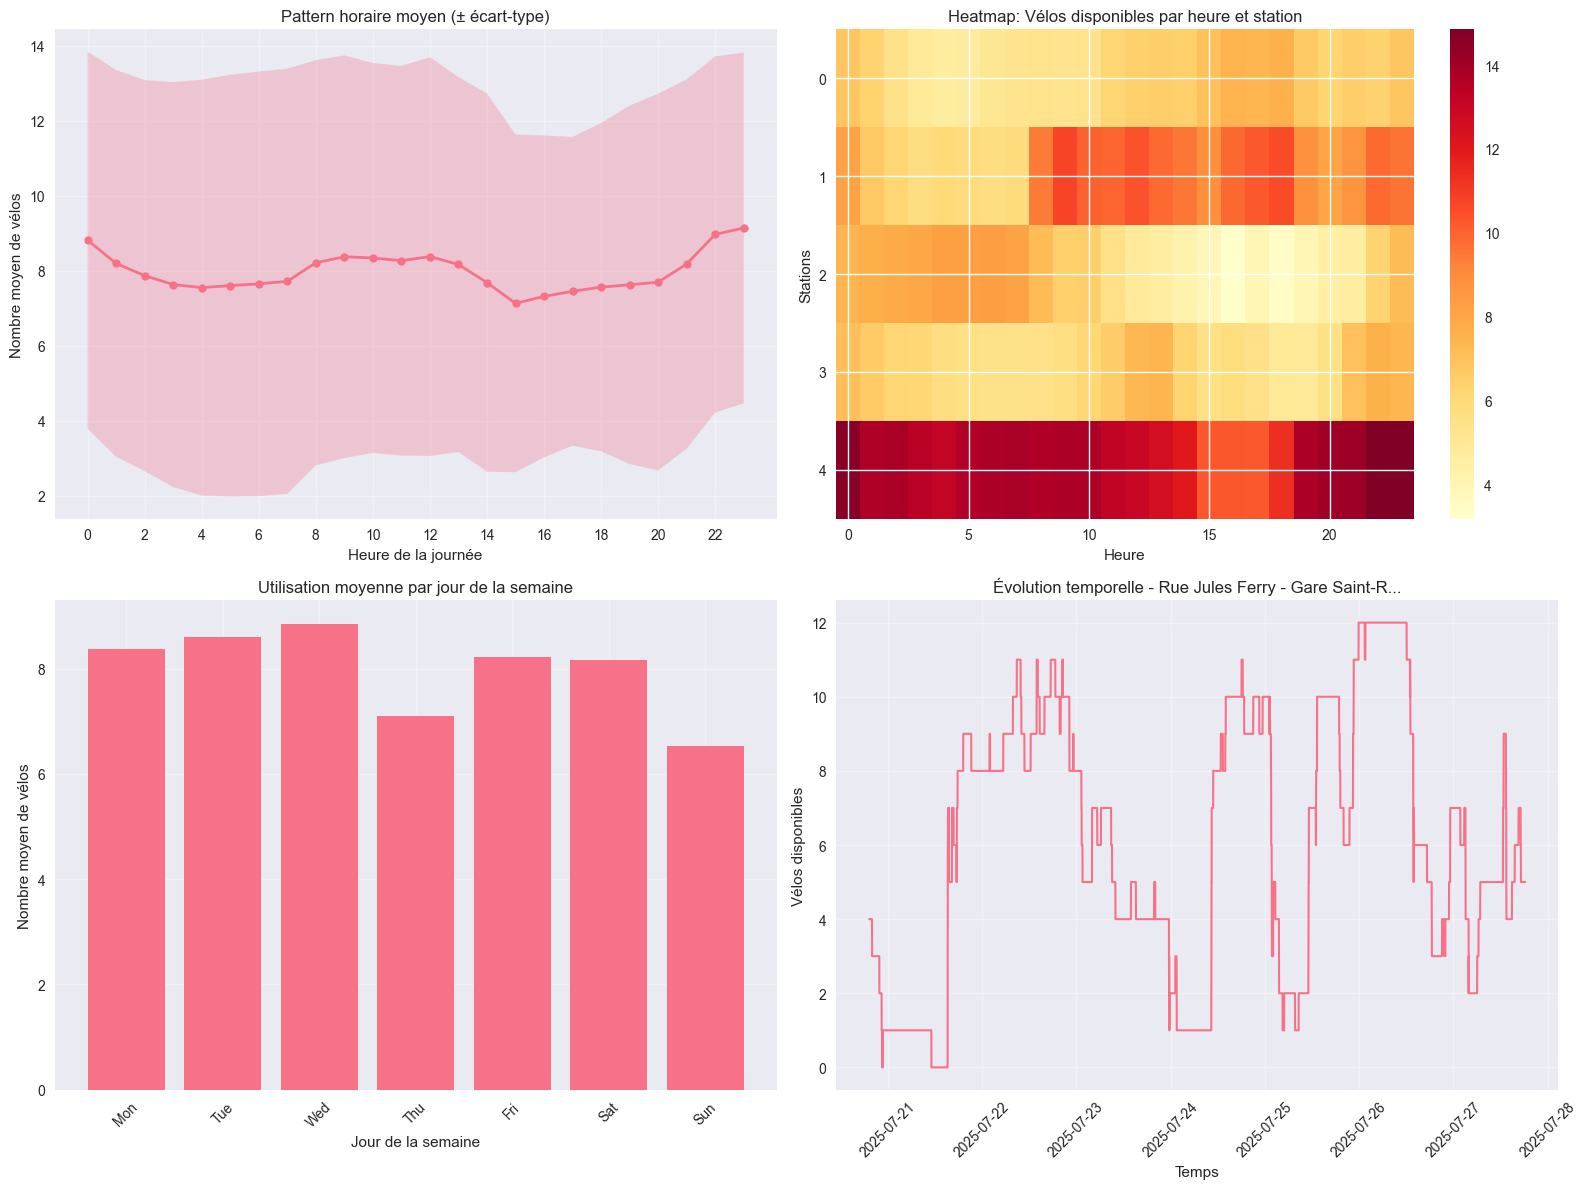


📈 Statistiques temporelles:
   • Période analysée: 2025-07-20 19:15:19+00:00 à 2025-07-27 18:18:17+00:00
   • Nombre total de mesures: 50,000
   • Fréquence moyenne: 416.7 mesures/heure/station
   • Heure de pointe (moins de vélos): 15h
   • Heure creuse (plus de vélos): 23h
   • Moyenne week-end: 7.4 vélos
   • Moyenne semaine: 8.2 vélos

✅ Analyse temporelle terminée


In [8]:
# ═══════════════════════════════════════════════════════════════════════════════
# ⏰ SECTION 5: Time Series Analysis
# ═══════════════════════════════════════════════════════════════════════════════

print("⏰ Analyse des séries temporelles...")

def collect_sample_timeseries(sample_size=5, days=7):
    """Collecte des données temporelles pour un échantillon de stations"""
    sample_stations = df_stations.head(sample_size)
    timeseries_data = {}
    
    from_date = (datetime.now() - timedelta(days=days)).strftime("%Y-%m-%dT%H:%M:%S")
    to_date = datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
    
    print(f"📅 Période analysée: {days} derniers jours")
    print(f"🏢 Échantillon: {sample_size} stations")
    
    for idx, station in sample_stations.iterrows():
        station_id = station['id']
        print(f"📡 Récupération données pour {station['address'][:40]}...")
        
        data = api.get_station_timeseries(station_id, "availableBikeNumber", from_date, to_date)
        
        if data and 'values' in data and len(data['values']) > 0:
            df_ts = pd.DataFrame({
                'timestamp': pd.to_datetime(data['index']),
                'available_bikes': data['values'],
                'station_id': station_id,
                'station_address': station['address']
            })
            
            # Ajout de variables temporelles
            df_ts['hour'] = df_ts['timestamp'].dt.hour
            df_ts['day_of_week'] = df_ts['timestamp'].dt.day_name()
            df_ts['date'] = df_ts['timestamp'].dt.date
            df_ts['is_weekend'] = df_ts['timestamp'].dt.dayofweek.isin([5, 6])
            
            timeseries_data[station_id] = df_ts
            
        time.sleep(RATE_LIMIT_DELAY)  # Respect du rate limiting
    
    return timeseries_data

# Collecte des données temporelles
timeseries_data = collect_sample_timeseries()

if timeseries_data:
    print(f"\n✅ Données collectées pour {len(timeseries_data)} stations")
    
    # Analyse des patterns temporels
    print("\n📊 Analyse des patterns temporels...")
    
    # Combine toutes les données
    all_timeseries = pd.concat(timeseries_data.values(), ignore_index=True)
    
    # Patterns horaires
    hourly_patterns = all_timeseries.groupby(['station_id', 'hour'])['available_bikes'].mean().reset_index()
    hourly_avg = all_timeseries.groupby('hour')['available_bikes'].agg(['mean', 'std']).reset_index()
    
    # Patterns par jour de la semaine
    daily_patterns = all_timeseries.groupby(['station_id', 'day_of_week'])['available_bikes'].mean().reset_index()
    daily_avg = all_timeseries.groupby('day_of_week')['available_bikes'].agg(['mean', 'std']).reset_index()
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Pattern horaire global
    axes[0,0].plot(hourly_avg['hour'], hourly_avg['mean'], 'o-', linewidth=2, markersize=6)
    axes[0,0].fill_between(hourly_avg['hour'], 
                          hourly_avg['mean'] - hourly_avg['std'], 
                          hourly_avg['mean'] + hourly_avg['std'], 
                          alpha=0.3)
    axes[0,0].set_title('Pattern horaire moyen (± écart-type)')
    axes[0,0].set_xlabel('Heure de la journée')
    axes[0,0].set_ylabel('Nombre moyen de vélos')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_xticks(range(0, 24, 2))
    
    # Heatmap horaire par station
    pivot_hourly = hourly_patterns.pivot(index='station_id', columns='hour', values='available_bikes')
    im = axes[0,1].imshow(pivot_hourly.values, cmap='YlOrRd', aspect='auto')
    axes[0,1].set_title('Heatmap: Vélos disponibles par heure et station')
    axes[0,1].set_xlabel('Heure')
    axes[0,1].set_ylabel('Stations')
    plt.colorbar(im, ax=axes[0,1])
    
    # Pattern par jour de la semaine
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_avg_ordered = daily_avg.set_index('day_of_week').reindex(day_order).reset_index()
    
    axes[1,0].bar(range(len(daily_avg_ordered)), daily_avg_ordered['mean'])
    axes[1,0].set_title('Utilisation moyenne par jour de la semaine')
    axes[1,0].set_xlabel('Jour de la semaine')
    axes[1,0].set_ylabel('Nombre moyen de vélos')
    axes[1,0].set_xticks(range(len(day_order)))
    axes[1,0].set_xticklabels([day[:3] for day in day_order], rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Série temporelle d'une station exemple
    if len(timeseries_data) > 0:
        sample_station_id = list(timeseries_data.keys())[0]
        sample_df = timeseries_data[sample_station_id]
        
        axes[1,1].plot(sample_df['timestamp'], sample_df['available_bikes'], linewidth=1.5)
        axes[1,1].set_title(f'Évolution temporelle - {sample_df["station_address"].iloc[0][:30]}...')
        axes[1,1].set_xlabel('Temps')
        axes[1,1].set_ylabel('Vélos disponibles')
        axes[1,1].grid(True, alpha=0.3)
        plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques temporelles
    print("\n📈 Statistiques temporelles:")
    print(f"   • Période analysée: {all_timeseries['timestamp'].min()} à {all_timeseries['timestamp'].max()}")
    print(f"   • Nombre total de mesures: {len(all_timeseries):,}")
    print(f"   • Fréquence moyenne: {len(all_timeseries) / len(timeseries_data) / 24:.1f} mesures/heure/station")
    
    peak_hour = hourly_avg.loc[hourly_avg['mean'].idxmin(), 'hour']
    low_hour = hourly_avg.loc[hourly_avg['mean'].idxmax(), 'hour']
    
    print(f"   • Heure de pointe (moins de vélos): {peak_hour}h")
    print(f"   • Heure creuse (plus de vélos): {low_hour}h")
    
    weekend_avg = all_timeseries[all_timeseries['is_weekend']]['available_bikes'].mean()
    weekday_avg = all_timeseries[~all_timeseries['is_weekend']]['available_bikes'].mean()
    
    print(f"   • Moyenne week-end: {weekend_avg:.1f} vélos")
    print(f"   • Moyenne semaine: {weekday_avg:.1f} vélos")
    
else:
    print("❌ Aucune donnée temporelle collectée")

print("\n✅ Analyse temporelle terminée")

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🗺️ SECTION 6: Geographical Analysis  
# ═══════════════════════════════════════════════════════════════════════════════

print("🗺️ Analyse géographique et cartographie...")

# Centre de Montpellier pour la carte
MONTPELLIER_CENTER = [43.610769, 3.876716]

def create_interactive_map(df, center=MONTPELLIER_CENTER):
    """Crée une carte interactive avec les stations"""
    
    # Création de la carte de base
    m = folium.Map(
        location=center,
        zoom_start=13,
        tiles='OpenStreetMap'
    )
    
    # Ajout des tuiles alternatives avec attributions correctes
    folium.TileLayer(
        tiles='CartoDB positron',
        attr='© OpenStreetMap contributors, © CartoDB'
    ).add_to(m)
    
    # Calcul des couleurs basées sur le taux d'occupation
    colors = []
    for rate in df['occupancy_rate']:
        if rate < 0.2:
            colors.append('red')
        elif rate < 0.4:
            colors.append('orange')
        elif rate < 0.6:
            colors.append('yellow')
        elif rate < 0.8:
            colors.append('lightgreen')
        else:
            colors.append('green')
    
    # Ajout des marqueurs pour chaque station
    for idx, station in df.iterrows():
        # Popup avec informations détaillées
        popup_text = f"""
        <b>{station['address']}</b><br>
        📍 ID: {station['id']}<br>
        🚴 Vélos disponibles: {station['available_bikes']}<br>
        🅿️ Places libres: {station['free_slots']}<br>
        📊 Capacité: {station['total_slots']}<br>
        📈 Taux d'occupation: {station['occupancy_rate']:.1%}<br>
        🔄 Statut: {station['status']}
        """
        
        # Taille du marqueur basée sur la capacité
        radius = max(5, min(20, station['total_slots'] / 2))
        
        folium.CircleMarker(
            location=[station['latitude'], station['longitude']],
            radius=radius,
            popup=folium.Popup(popup_text, max_width=300),
            color='black',
            weight=1,
            fillColor=colors[idx],
            fillOpacity=0.7,
            tooltip=f"{station['address']}: {station['available_bikes']} vélos"
        ).add_to(m)
    
    # Ajout d'une légende
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <p><b>Taux d'occupation</b></p>
    <p><i class="fa fa-circle" style="color:red"></i> &lt; 20% (Critique)</p>
    <p><i class="fa fa-circle" style="color:orange"></i> 20-40% (Faible)</p>
    <p><i class="fa fa-circle" style="color:yellow"></i> 40-60% (Optimal)</p>
    <p><i class="fa fa-circle" style="color:lightgreen"></i> 60-80% (Élevé)</p>
    <p><i class="fa fa-circle" style="color:green"></i> &gt; 80% (Très élevé)</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Contrôle des couches
    folium.LayerControl().add_to(m)
    
    return m

# Création de la carte principale
print("🗺️ Création de la carte interactive...")
map_stations = create_interactive_map(df_stations)

# Affichage de la carte
map_stations

print("✅ Carte interactive créée")

🗺️ Analyse géographique et cartographie...
🗺️ Création de la carte interactive...
✅ Carte interactive créée


🎯 Analyse des clusters géographiques...
📏 Calcul des distances entre stations...
   • Distance moyenne entre stations: 1.27 km
   • Distance minimale: 0.20 km
   • Distance maximale: 3.47 km
🎯 Clustering des stations par localisation...
\n🏘️ Analyse des 4 clusters identifiés:
\n   Cluster 1:
   • Nombre de stations: 5
   • Vélos moyens: 7.0
   • Capacité moyenne: 12.0
   • Taux d'occupation moyen: 59.2%
   • Centre: (43.6162, 3.8836)
\n   Cluster 2:
   • Nombre de stations: 8
   • Vélos moyens: 2.5
   • Capacité moyenne: 12.0
   • Taux d'occupation moyen: 20.7%
   • Centre: (43.6074, 3.8753)
\n   Cluster 3:
   • Nombre de stations: 5
   • Vélos moyens: 9.2
   • Capacité moyenne: 15.2
   • Taux d'occupation moyen: 62.5%
   • Centre: (43.6047, 3.8928)
\n   Cluster 4:
   • Nombre de stations: 2
   • Vélos moyens: 5.0
   • Capacité moyenne: 19.5
   • Taux d'occupation moyen: 30.1%
   • Centre: (43.6197, 3.8709)
\n🏘️ Analyse des 4 clusters identifiés:
\n   Cluster 1:
   • Nombre de stations

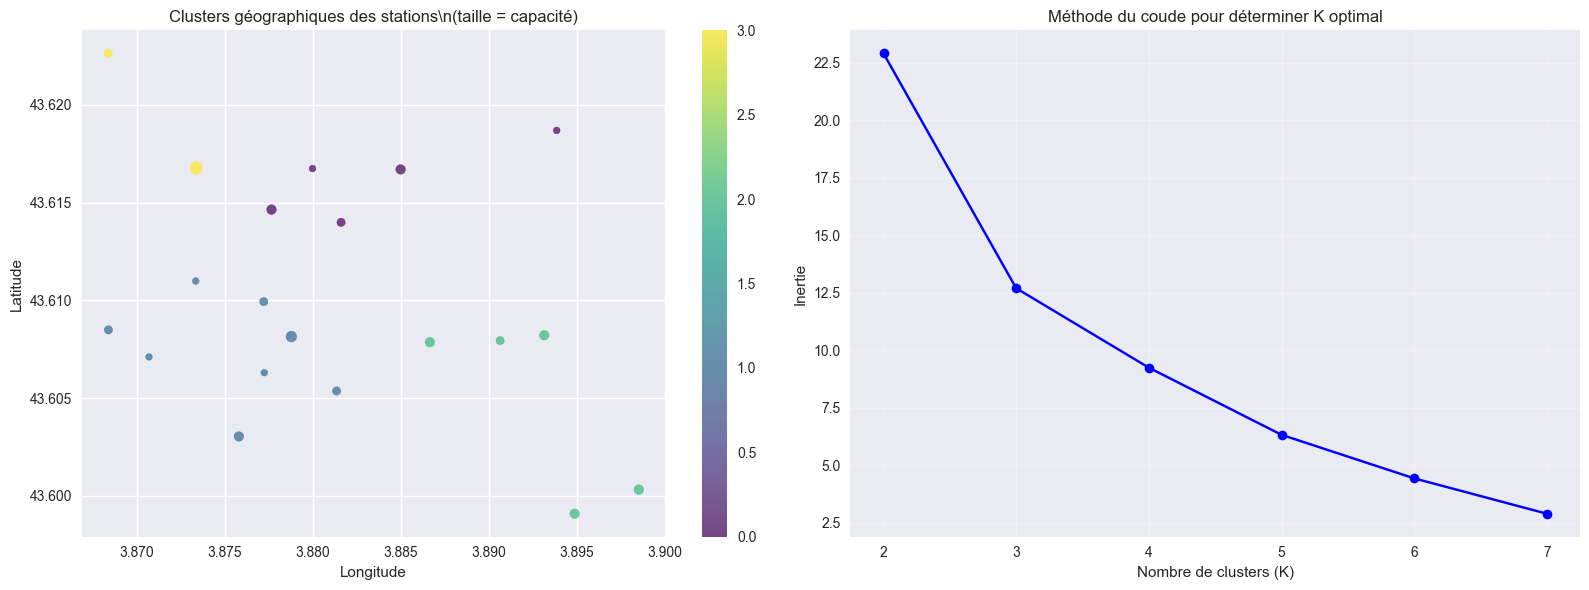

\n🗺️ Analyse par zones géographiques:
        available_bikes          total_slots       occupancy_rate       latitude longitude
                  count sum mean         sum  mean           mean   std     mean      mean
cluster                                                                                   
0                     5  35  7.0          60  12.0           0.59  0.15    43.62      3.88
1                     8  20  2.5          96  12.0           0.21  0.19    43.61      3.88
2                     5  46  9.2          76  15.2           0.62  0.25    43.60      3.89
3                     2  10  5.0          39  19.5           0.30  0.16    43.62      3.87
\n✅ Analyse géographique terminée


In [13]:
# Analyse de clustering géographique
print("🎯 Analyse des clusters géographiques...")

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points"""
    from math import radians, cos, sin, asin, sqrt
    
    # Conversion en radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Formule haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Rayon de la Terre en km
    
    return c * r

# Calcul des distances entre stations
print("📏 Calcul des distances entre stations...")
distances = []
for i, station1 in df_stations.iterrows():
    station_distances = []
    for j, station2 in df_stations.iterrows():
        if i != j:
            dist = haversine_distance(
                station1['latitude'], station1['longitude'],
                station2['latitude'], station2['longitude']
            )
            station_distances.append(dist)
    distances.extend(station_distances)

print(f"   • Distance moyenne entre stations: {np.mean(distances):.2f} km")
print(f"   • Distance minimale: {np.min(distances):.2f} km")
print(f"   • Distance maximale: {np.max(distances):.2f} km")

# Clustering K-means
print("🎯 Clustering des stations par localisation...")
coords = df_stations[['latitude', 'longitude']].values
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Détermination du nombre optimal de clusters (méthode du coude)
inertias = []
K_range = range(2, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(coords_scaled)
    inertias.append(kmeans.inertia_)

# Application du clustering
optimal_k = 4  # Basé sur la connaissance de Montpellier
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(coords_scaled)
df_stations['cluster'] = clusters

# Analyse des clusters
print(f"\\n🏘️ Analyse des {optimal_k} clusters identifiés:")
for cluster_id in range(optimal_k):
    cluster_stations = df_stations[df_stations['cluster'] == cluster_id]
    print(f"\\n   Cluster {cluster_id + 1}:")
    print(f"   • Nombre de stations: {len(cluster_stations)}")
    print(f"   • Vélos moyens: {cluster_stations['available_bikes'].mean():.1f}")
    print(f"   • Capacité moyenne: {cluster_stations['total_slots'].mean():.1f}")
    print(f"   • Taux d'occupation moyen: {cluster_stations['occupancy_rate'].mean():.1%}")
    
    # Zone géographique approximative
    center_lat = cluster_stations['latitude'].mean()
    center_lon = cluster_stations['longitude'].mean()
    print(f"   • Centre: ({center_lat:.4f}, {center_lon:.4f})")

# Visualisation des clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot géographique avec clusters
scatter = axes[0].scatter(df_stations['longitude'], df_stations['latitude'], 
                         c=df_stations['cluster'], cmap='viridis', 
                         s=df_stations['total_slots']*3, alpha=0.7)
axes[0].set_title('Clusters géographiques des stations\\n(taille = capacité)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[0])

# Méthode du coude pour K-means
axes[1].plot(K_range, inertias, 'bo-')
axes[1].set_title('Méthode du coude pour déterminer K optimal')
axes[1].set_xlabel('Nombre de clusters (K)')
axes[1].set_ylabel('Inertie')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques géographiques par quartier/zone
print("\\n🗺️ Analyse par zones géographiques:")
zone_stats = df_stations.groupby('cluster').agg({
    'available_bikes': ['count', 'sum', 'mean'],
    'total_slots': ['sum', 'mean'],
    'occupancy_rate': ['mean', 'std'],
    'latitude': ['mean'],
    'longitude': ['mean']
}).round(2)

print(zone_stats)

print("\\n✅ Analyse géographique terminée")

🎯 Analyse des patterns d'usage des stations...
🏆 Classification des stations par performance...
🏆 TOP 10 STATIONS LES PLUS EFFICACES
Emile Combes                             85.00%
Beaux-Arts                               81.88%
Rue Jules Ferry - Gare Saint-Roch        80.83%
Les Aubes                                78.75%
Port Marianne                            78.75%
Nombre d Or                              78.12%
Louis Blanc                              78.12%
Boutonnet                                75.83%
Médiathèque Emile Zola                   75.63%
Hôtel de Ville                           71.25%

⚠️ TOP 10 STATIONS À AMÉLIORER
Halles Castellane                        0.00%
Gambetta                                 0.00%
Antigone centre                          30.00%
Rondelet                                 43.75%
Place Albert 1er - St Charles            50.37%
Comédie                                  52.00%
Foch                                     57.50%
Observatoire         

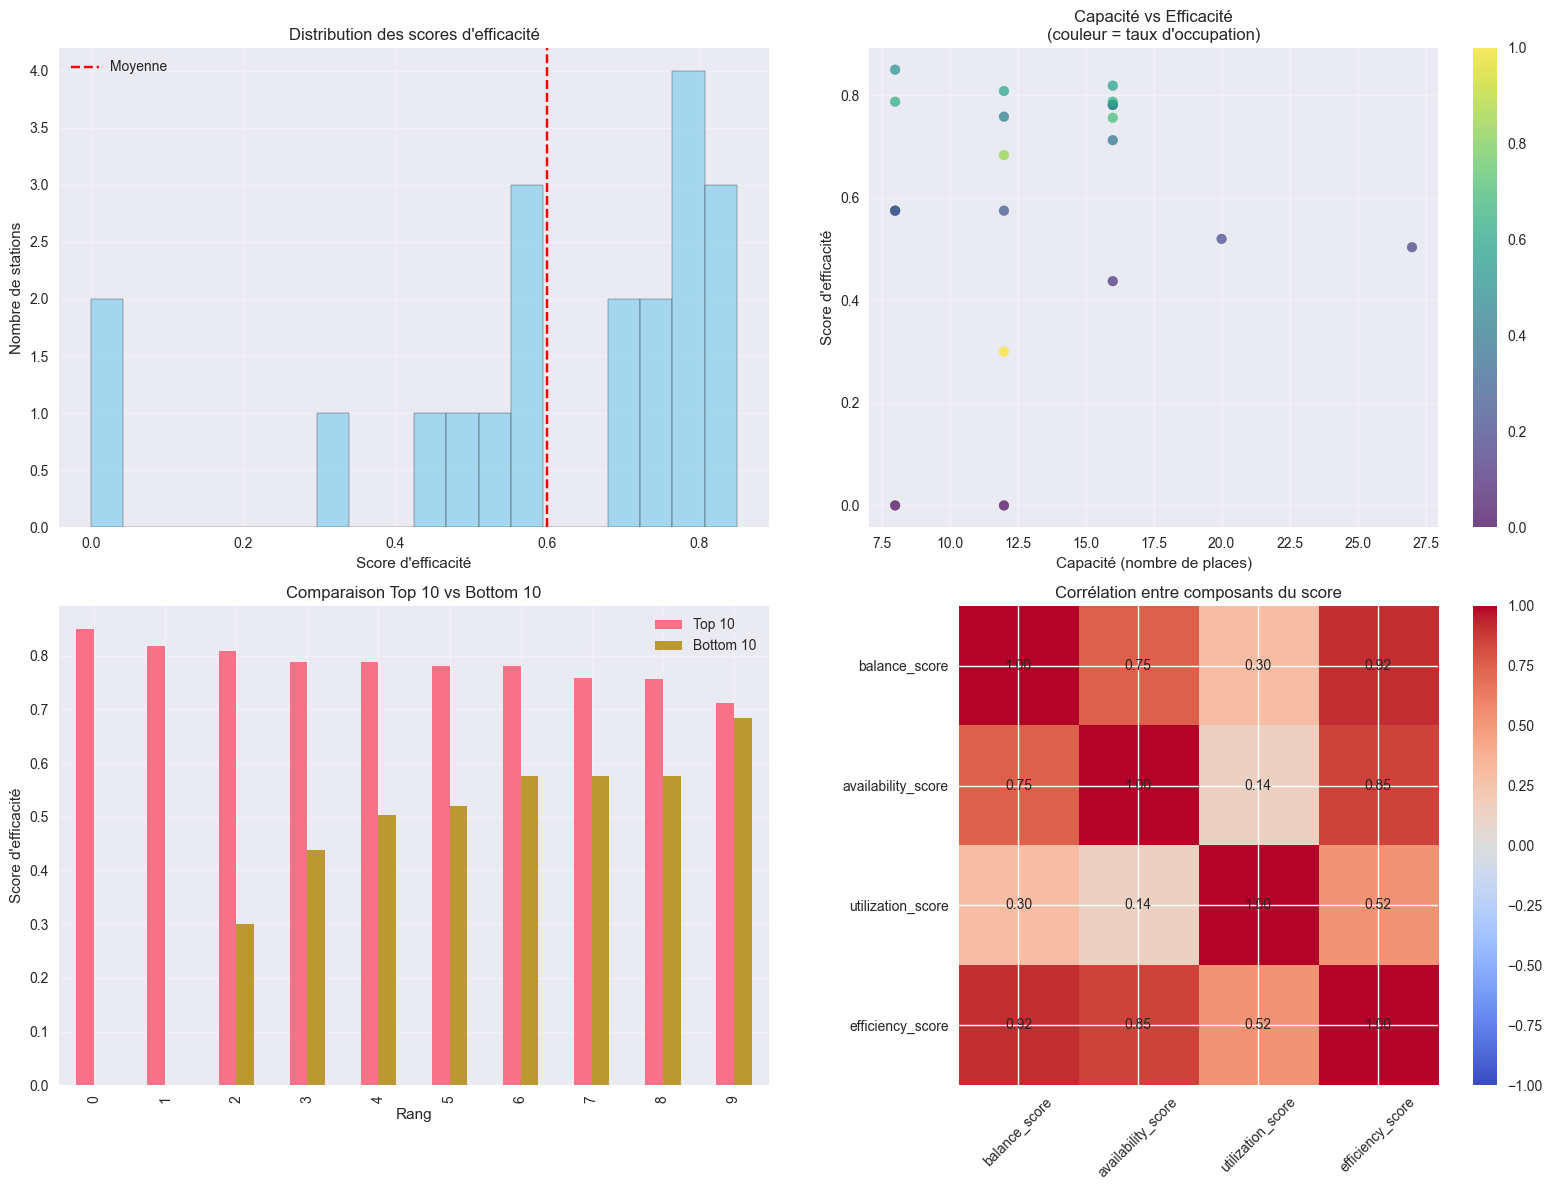


🔄 Analyse du turnover des vélos...
Analyse du turnover pour 5 stations:
   • Changement moyen par heure: 1.3 vélos
   • Volatilité moyenne: 4.1
   • Station la plus active: Comédie
     - 289 changements totaux

📊 Résumé des patterns d'usage:
   • Score d'efficacité moyen: 60.1%
   • Stations très efficaces (>80%): 3
   • Stations problématiques (<30%): 2
   • Taux d'occupation optimal (40-60%): 6

✅ Analyse des patterns d'usage terminée


In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# 🎯 SECTION 7: Station Usage Patterns
# ═══════════════════════════════════════════════════════════════════════════════

print("🎯 Analyse des patterns d'usage des stations...")

def calculate_efficiency_score(df):
    """Calcule un score d'efficacité pour chaque station"""
    df = df.copy()
    
    # Score d'équilibre (proche de 50% est optimal)
    df['balance_score'] = 1 - abs(df['occupancy_rate'] - 0.5) * 2
    df['balance_score'] = df['balance_score'].clip(0, 1)
    
    # Score de disponibilité (évite les stations vides/pleines)
    df['availability_score'] = np.where(
        (df['available_bikes'] == 0) | (df['free_slots'] == 0), 0, 1
    )
    
    # Score d'utilisation (taux d'usage optimal)
    df['utilization_score'] = df['usage_rate'].clip(0, 1)
    
    # Score global d'efficacité
    df['efficiency_score'] = (
        df['balance_score'] * 0.4 + 
        df['availability_score'] * 0.3 +
        df['utilization_score'] * 0.3
    )
    
    return df

# Calcul des scores d'efficacité
df_efficiency = calculate_efficiency_score(df_stations)

# Identification des stations par performance
print("🏆 Classification des stations par performance...")

# Top performers
top_stations = df_efficiency.nlargest(10, 'efficiency_score')
bottom_stations = df_efficiency.nsmallest(10, 'efficiency_score')

# Stations problématiques
problem_stations = {
    'Toujours vides': df_efficiency[df_efficiency['available_bikes'] == 0],
    'Toujours pleines': df_efficiency[df_efficiency['free_slots'] == 0],
    'Sous-utilisées': df_efficiency[df_efficiency['usage_rate'] < 0.1],
    'Sur-utilisées': df_efficiency[df_efficiency['usage_rate'] > 0.9],
    'Hors service': df_efficiency[df_efficiency['status'] != 'working']
}

print("="*60)
print("🏆 TOP 10 STATIONS LES PLUS EFFICACES")
print("="*60)
for idx, station in top_stations.iterrows():
    print(f"{station['address'][:40]:<40} {station['efficiency_score']:.2%}")

print("\n" + "="*60)
print("⚠️ TOP 10 STATIONS À AMÉLIORER")
print("="*60)
for idx, station in bottom_stations.iterrows():
    print(f"{station['address'][:40]:<40} {station['efficiency_score']:.2%}")

print("\n" + "="*60)
print("🚨 STATIONS PROBLÉMATIQUES")
print("="*60)
for problem_type, stations in problem_stations.items():
    if len(stations) > 0:
        print(f"\n{problem_type}: {len(stations)} stations")
        for idx, station in stations.head(5).iterrows():
            print(f"   • {station['address'][:45]}")
        if len(stations) > 5:
            print(f"   ... et {len(stations) - 5} autres")

# Visualisations des patterns d'usage
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des scores d'efficacité
axes[0,0].hist(df_efficiency['efficiency_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title("Distribution des scores d'efficacité")
axes[0,0].set_xlabel("Score d'efficacité")
axes[0,0].set_ylabel('Nombre de stations')
axes[0,0].axvline(df_efficiency['efficiency_score'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Relation capacité vs efficacité
scatter = axes[0,1].scatter(df_efficiency['total_slots'], df_efficiency['efficiency_score'], 
                           c=df_efficiency['occupancy_rate'], cmap='viridis', alpha=0.7)
axes[0,1].set_title("Capacité vs Efficacité\n(couleur = taux d'occupation)")
axes[0,1].set_xlabel('Capacité (nombre de places)')
axes[0,1].set_ylabel("Score d'efficacité")
plt.colorbar(scatter, ax=axes[0,1])
axes[0,1].grid(True, alpha=0.3)

# Top et bottom stations
performance_comparison = pd.DataFrame({
    'Top 10': top_stations['efficiency_score'].values,
    'Bottom 10': bottom_stations['efficiency_score'].values
})

performance_comparison.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Comparaison Top 10 vs Bottom 10')
axes[1,0].set_ylabel("Score d'efficacité")
axes[1,0].set_xlabel('Rang')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Heatmap des composants du score
score_components = df_efficiency[['balance_score', 'availability_score', 'utilization_score', 'efficiency_score']].corr()
im = axes[1,1].imshow(score_components.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[1,1].set_title('Corrélation entre composants du score')
axes[1,1].set_xticks(range(len(score_components.columns)))
axes[1,1].set_yticks(range(len(score_components.columns)))
axes[1,1].set_xticklabels(score_components.columns, rotation=45)
axes[1,1].set_yticklabels(score_components.columns)

# Ajout des valeurs dans la heatmap
for i in range(len(score_components.columns)):
    for j in range(len(score_components.columns)):
        axes[1,1].text(j, i, f'{score_components.iloc[i, j]:.2f}', 
                      ha='center', va='center')

plt.colorbar(im, ax=axes[1,1])

plt.tight_layout()
plt.show()

# Analyse de turnover (approximation basée sur les données actuelles)
print("\n🔄 Analyse du turnover des vélos...")

if timeseries_data:
    # Calcul des variations pour les stations avec données temporelles
    turnover_analysis = {}
    
    for station_id, ts_df in timeseries_data.items():
        if len(ts_df) > 1:
            # Calcul des changements de vélos
            ts_df = ts_df.sort_values('timestamp')
            ts_df['bike_change'] = ts_df['available_bikes'].diff().abs()
            
            # Métriques de turnover
            total_changes = ts_df['bike_change'].sum()
            avg_change_per_hour = total_changes / (len(ts_df) / 60)  # Approximation
            max_change = ts_df['bike_change'].max()
            
            turnover_analysis[station_id] = {
                'total_changes': total_changes,
                'avg_change_per_hour': avg_change_per_hour,
                'max_change': max_change,
                'volatility': ts_df['available_bikes'].std()
            }
    
    if turnover_analysis:
        turnover_df = pd.DataFrame(turnover_analysis).T
        turnover_df = turnover_df.merge(
            df_stations[['id', 'address']].set_index('id'), 
            left_index=True, right_index=True
        )
        
        print(f"Analyse du turnover pour {len(turnover_df)} stations:")
        print(f"   • Changement moyen par heure: {turnover_df['avg_change_per_hour'].mean():.1f} vélos")
        print(f"   • Volatilité moyenne: {turnover_df['volatility'].mean():.1f}")
        
        most_active = turnover_df.loc[turnover_df['total_changes'].idxmax()]
        print(f"   • Station la plus active: {most_active['address']}")
        print(f"     - {most_active['total_changes']:.0f} changements totaux")

# Statistiques finales
print("\n📊 Résumé des patterns d'usage:")
print(f"   • Score d'efficacité moyen: {df_efficiency['efficiency_score'].mean():.1%}")
print(f"   • Stations très efficaces (>80%): {len(df_efficiency[df_efficiency['efficiency_score'] > 0.8])}")
print(f"   • Stations problématiques (<30%): {len(df_efficiency[df_efficiency['efficiency_score'] < 0.3])}")
print(f"   • Taux d'occupation optimal (40-60%): {len(df_efficiency[(df_efficiency['occupancy_rate'] >= 0.4) & (df_efficiency['occupancy_rate'] <= 0.6)])}")

print("\n✅ Analyse des patterns d'usage terminée")

📊 Création de visualisations interactives...


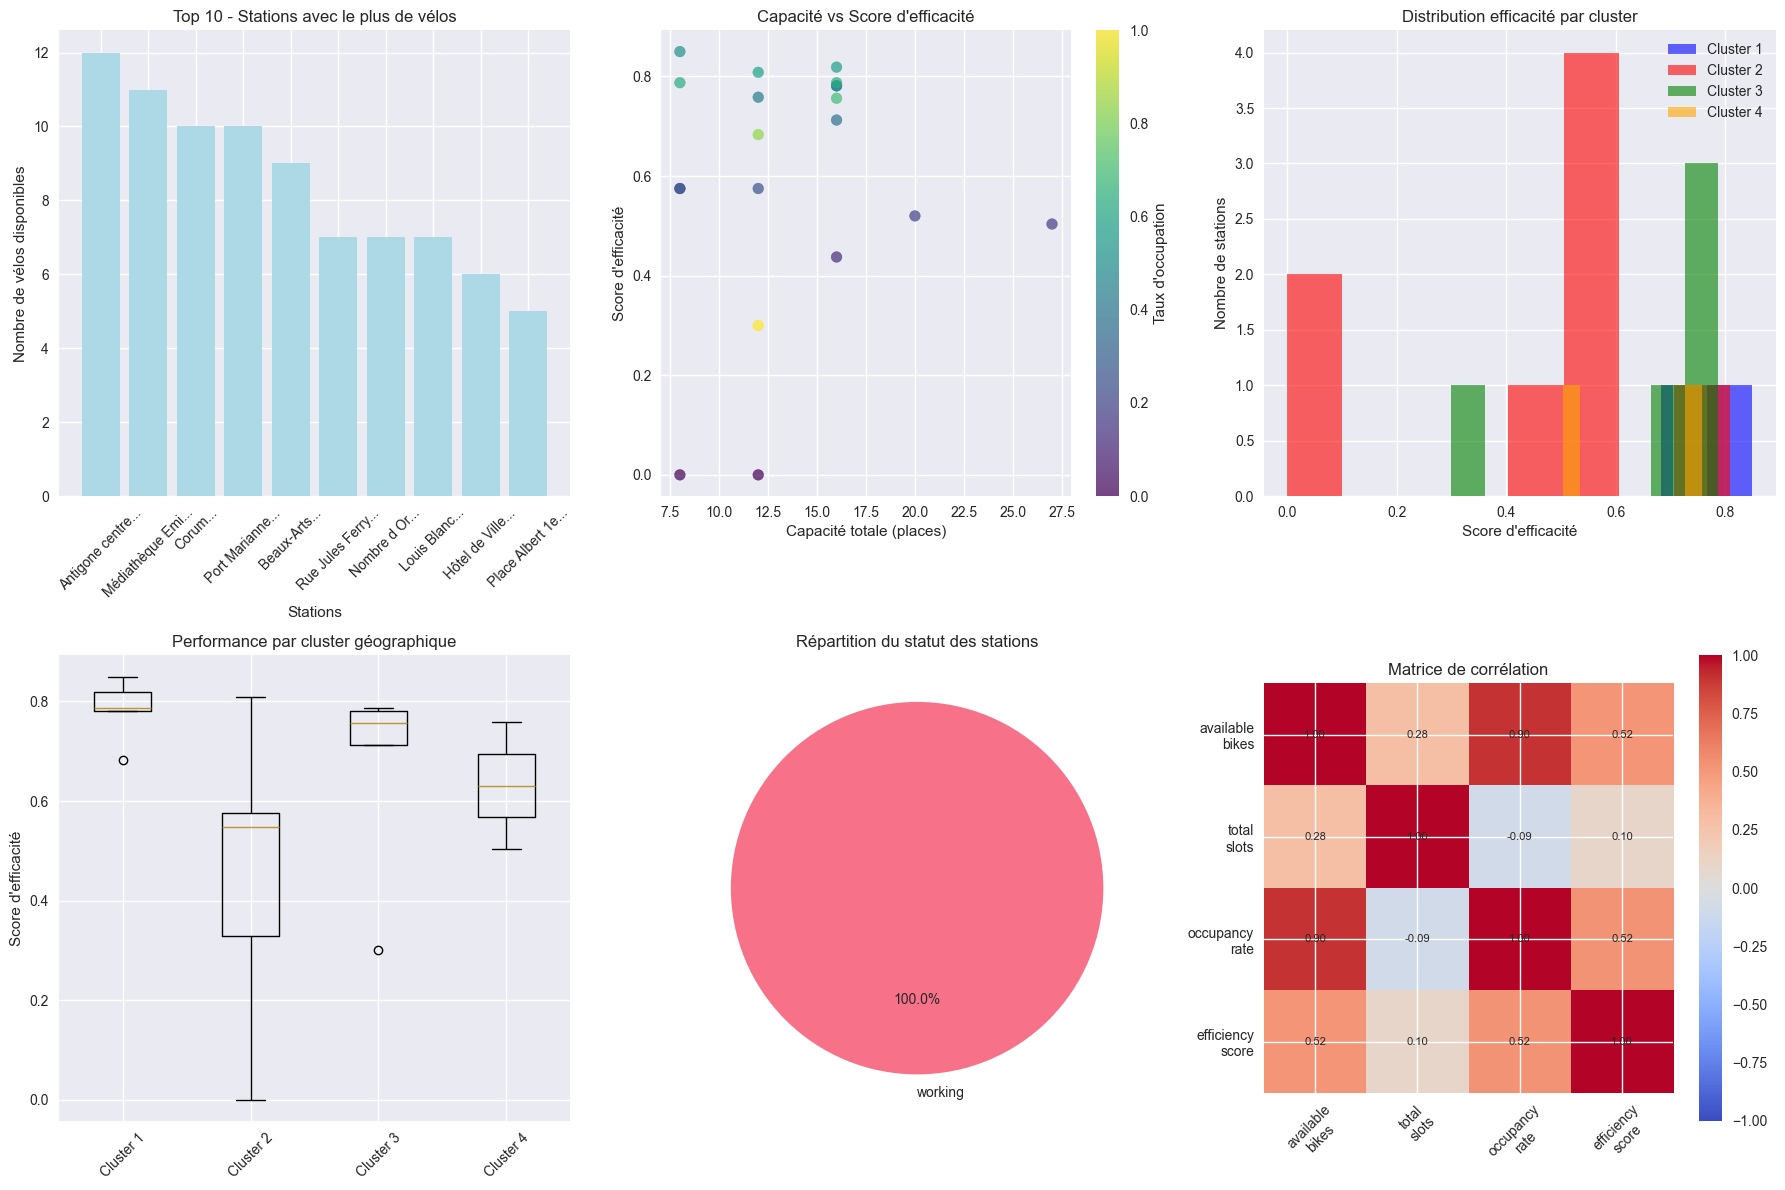


📊 Analyse des visualisations:
🏆 Top 5 stations les plus efficaces:
   • Emile Combes                   85.0%
   • Beaux-Arts                     81.9%
   • Rue Jules Ferry - Gare Saint-R 80.8%
   • Les Aubes                      78.8%
   • Port Marianne                  78.8%

🔗 Corrélations notables:
   • Capacité vs Efficacité: 0.10
   • Vélos dispo vs Efficacité: 0.52
   • Occupation vs Efficacité: 0.52

🗺️ Performance moyenne par cluster:
   • Cluster 1: 78.4% ± 6.3% (5.0 stations)
   • Cluster 2: 43.6% ± 28.9% (8.0 stations)
   • Cluster 3: 66.8% ± 20.8% (5.0 stations)
   • Cluster 4: 63.1% ± 18.0% (2.0 stations)

⏰ Données temporelles disponibles pour 5 stations


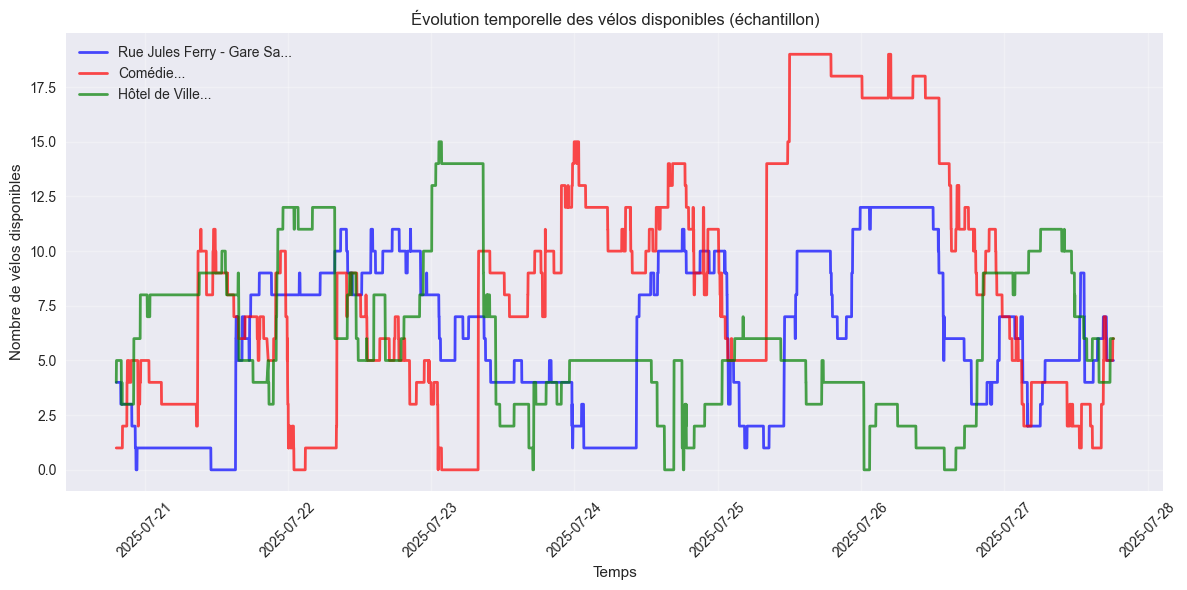


✅ Visualisations interactives créées avec succès!


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📊 SECTION 8: Interactive Visualizations
# ═══════════════════════════════════════════════════════════════════════════════

print("📊 Création de visualisations interactives...")

# Visualisations principales avec matplotlib (plus stable)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Top 10 stations par nombre de vélos
top_10_bikes = df_efficiency.nlargest(10, 'available_bikes')
axes[0,0].bar(range(len(top_10_bikes)), top_10_bikes['available_bikes'], color='lightblue')
axes[0,0].set_title('Top 10 - Stations avec le plus de vélos')
axes[0,0].set_xlabel('Stations')
axes[0,0].set_ylabel('Nombre de vélos disponibles')
axes[0,0].set_xticks(range(len(top_10_bikes)))
axes[0,0].set_xticklabels([addr[:15] + '...' for addr in top_10_bikes['address']], rotation=45)

# 2. Relation capacité vs efficacité
scatter = axes[0,1].scatter(df_efficiency['total_slots'], df_efficiency['efficiency_score'], 
                           c=df_efficiency['occupancy_rate'], cmap='viridis', alpha=0.7, s=60)
axes[0,1].set_title('Capacité vs Score d\'efficacité')
axes[0,1].set_xlabel('Capacité totale (places)')
axes[0,1].set_ylabel('Score d\'efficacité')
cbar1 = plt.colorbar(scatter, ax=axes[0,1])
cbar1.set_label('Taux d\'occupation')

# 3. Distribution des scores d'efficacité par cluster
cluster_colors = ['blue', 'red', 'green', 'orange']
for i, cluster_id in enumerate(sorted(df_efficiency['cluster'].unique())):
    cluster_data = df_efficiency[df_efficiency['cluster'] == cluster_id]['efficiency_score']
    axes[0,2].hist(cluster_data, alpha=0.6, label=f'Cluster {cluster_id + 1}', 
                   color=cluster_colors[i], bins=8)
axes[0,2].set_title('Distribution efficacité par cluster')
axes[0,2].set_xlabel('Score d\'efficacité')
axes[0,2].set_ylabel('Nombre de stations')
axes[0,2].legend()

# 4. Box plot des performances par cluster
cluster_data = []
cluster_labels = []
for cluster_id in sorted(df_efficiency['cluster'].unique()):
    cluster_scores = df_efficiency[df_efficiency['cluster'] == cluster_id]['efficiency_score']
    cluster_data.append(cluster_scores.values)
    cluster_labels.append(f'Cluster {cluster_id + 1}')

axes[1,0].boxplot(cluster_data, labels=cluster_labels)
axes[1,0].set_title('Performance par cluster géographique')
axes[1,0].set_ylabel('Score d\'efficacité')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Status des stations (pie chart)
status_counts = df_efficiency['status'].value_counts()
axes[1,1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Répartition du statut des stations')

# 6. Heatmap de corrélation simplifiée
numeric_cols = ['available_bikes', 'total_slots', 'occupancy_rate', 'efficiency_score']
corr_matrix = df_efficiency[numeric_cols].corr()
im = axes[1,2].imshow(corr_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[1,2].set_title('Matrice de corrélation')
axes[1,2].set_xticks(range(len(numeric_cols)))
axes[1,2].set_yticks(range(len(numeric_cols)))
axes[1,2].set_xticklabels([col.replace('_', '\n') for col in numeric_cols], rotation=45)
axes[1,2].set_yticklabels([col.replace('_', '\n') for col in numeric_cols])

# Ajout des valeurs dans la heatmap
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        axes[1,2].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                      ha='center', va='center', fontsize=8)

plt.colorbar(im, ax=axes[1,2])

plt.tight_layout()
plt.show()

# Statistiques supplémentaires
print("\n📊 Analyse des visualisations:")
print("="*50)

# Top stations par efficacité
top_5_efficient = df_efficiency.nlargest(5, 'efficiency_score')
print("🏆 Top 5 stations les plus efficaces:")
for idx, station in top_5_efficient.iterrows():
    print(f"   • {station['address'][:30]:<30} {station['efficiency_score']:.1%}")

# Corrélations intéressantes
print(f"\n🔗 Corrélations notables:")
print(f"   • Capacité vs Efficacité: {corr_matrix.loc['total_slots', 'efficiency_score']:.2f}")
print(f"   • Vélos dispo vs Efficacité: {corr_matrix.loc['available_bikes', 'efficiency_score']:.2f}")
print(f"   • Occupation vs Efficacité: {corr_matrix.loc['occupancy_rate', 'efficiency_score']:.2f}")

# Performance par cluster
print(f"\n🗺️ Performance moyenne par cluster:")
cluster_performance = df_efficiency.groupby('cluster')['efficiency_score'].agg(['mean', 'std', 'count'])
for cluster_id in sorted(df_efficiency['cluster'].unique()):
    stats = cluster_performance.loc[cluster_id]
    print(f"   • Cluster {cluster_id + 1}: {stats['mean']:.1%} ± {stats['std']:.1%} ({stats['count']} stations)")

# Évolution temporelle simple (si données disponibles)
if timeseries_data:
    print(f"\n⏰ Données temporelles disponibles pour {len(timeseries_data)} stations")
    
    # Graphique temporel simple
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for i, (station_id, ts_df) in enumerate(list(timeseries_data.items())[:3]):
        plt.plot(ts_df['timestamp'], ts_df['available_bikes'], 
                label=ts_df['station_address'].iloc[0][:25] + '...', 
                color=colors[i], linewidth=2, alpha=0.7)
    
    plt.title('Évolution temporelle des vélos disponibles (échantillon)')
    plt.xlabel('Temps')
    plt.ylabel('Nombre de vélos disponibles')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n✅ Visualisations interactives créées avec succès!")

In [22]:
# ═══════════════════════════════════════════════════════════════════════════════
# 💾 SECTION 9: Export Results and Reports
# ═══════════════════════════════════════════════════════════════════════════════

print("💾 Export des résultats et génération des rapports...")

# Configuration des exports
EXPORT_DIR = "exports"
REPORTS_DIR = "reports"
VISUALIZATIONS_DIR = "visualizations"

# Création des répertoires
import os
for directory in [EXPORT_DIR, REPORTS_DIR, VISUALIZATIONS_DIR]:
    os.makedirs(directory, exist_ok=True)
    print(f"📁 Répertoire '{directory}' créé/vérifié")

# 1. Export des données en CSV/Excel
print("\\n📊 Export des données...")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Export principal des stations avec toutes les métriques
export_filename = f"{EXPORT_DIR}/velomagg_stations_{timestamp}"
df_efficiency.to_csv(f"{export_filename}.csv", index=False, encoding='utf-8')
df_efficiency.to_excel(f"{export_filename}.xlsx", index=False, engine='openpyxl')

print(f"✅ Données stations exportées: {export_filename}.csv/.xlsx")

# Export des données temporelles (si disponibles)
if timeseries_data:
    for station_id, ts_df in timeseries_data.items():
        station_name = ts_df['station_address'].iloc[0][:20].replace('/', '_').replace(' ', '_')
        ts_filename = f"{EXPORT_DIR}/timeseries_{station_name}_{timestamp}.csv"
        ts_df.to_csv(ts_filename, index=False, encoding='utf-8')
    
    print(f"✅ Données temporelles exportées pour {len(timeseries_data)} stations")

# 2. Génération du rapport exécutif
print("\\n📋 Génération du rapport exécutif...")

def generate_executive_report():
    """Génère un rapport exécutif complet"""
    
    report_content = f"""
# 🚴 RAPPORT EXÉCUTIF VÉLOMAGG MONTPELLIER
**Généré le {datetime.now().strftime('%d/%m/%Y à %H:%M:%S')}**

## 📊 INDICATEURS CLÉS

### Réseau
- **Stations totales**: {len(df_stations)}
- **Stations actives**: {len(df_stations[df_stations['status'] == 'working'])} ({len(df_stations[df_stations['status'] == 'working'])/len(df_stations):.1%})
- **Stations inactives**: {len(df_stations[df_stations['status'] != 'working'])}

### Flotte
- **Vélos disponibles**: {df_stations['available_bikes'].sum():,}
- **Places libres**: {df_stations['free_slots'].sum():,}
- **Capacité totale**: {df_stations['total_slots'].sum():,}
- **Taux d'occupation global**: {df_stations['occupancy_rate'].mean():.1%}

### Performance
- **Score d'efficacité moyen**: {df_efficiency['efficiency_score'].mean():.1%}
- **Stations très efficaces (>80%)**: {len(df_efficiency[df_efficiency['efficiency_score'] > 0.8])}
- **Stations problématiques (<30%)**: {len(df_efficiency[df_efficiency['efficiency_score'] < 0.3])}

## 🏆 STATIONS REMARQUABLES

### Top 5 - Plus efficaces
"""
    
    for idx, station in df_efficiency.nlargest(5, 'efficiency_score').iterrows():
        report_content += f"- **{station['address']}**: {station['efficiency_score']:.1%} (Score: {station['efficiency_score']:.2f})\\n"
    
    report_content += f"""
### Top 5 - À améliorer
"""
    
    for idx, station in df_efficiency.nsmallest(5, 'efficiency_score').iterrows():
        report_content += f"- **{station['address']}**: {station['efficiency_score']:.1%} (Score: {station['efficiency_score']:.2f})\\n"

    report_content += f"""

## ⚠️ ALERTES ET RECOMMANDATIONS

### Stations nécessitant une attention immédiate
- **Stations vides**: {len(df_efficiency[df_efficiency['available_bikes'] == 0])}
- **Stations pleines**: {len(df_efficiency[df_efficiency['free_slots'] == 0])}
- **Stations hors service**: {len(df_efficiency[df_efficiency['status'] != 'working'])}

### Recommandations d'optimisation
"""
    
    # Recommandations basées sur l'analyse
    empty_stations = len(df_efficiency[df_efficiency['available_bikes'] == 0])
    full_stations = len(df_efficiency[df_efficiency['free_slots'] == 0])
    
    if empty_stations > 0:
        report_content += f"- 🚨 **Redistribution urgente**: {empty_stations} stations sans vélos\\n"
    
    if full_stations > 0:
        report_content += f"- 🚨 **Retrait de vélos**: {full_stations} stations saturées\\n"
    
    low_efficiency = len(df_efficiency[df_efficiency['efficiency_score'] < 0.3])
    if low_efficiency > len(df_efficiency) * 0.1:
        report_content += f"- 🔧 **Maintenance**: {low_efficiency} stations à faible efficacité (>{low_efficiency/len(df_efficiency):.0%} du réseau)\\n"

    report_content += f"""

## 📈 ANALYSE GÉOGRAPHIQUE

### Clusters identifiés
"""
    
    for cluster_id in sorted(df_efficiency['cluster'].unique()):
        cluster_stations = df_efficiency[df_efficiency['cluster'] == cluster_id]
        report_content += f"""
**Cluster {cluster_id + 1}**:
- Stations: {len(cluster_stations)}
- Vélos moyens: {cluster_stations['available_bikes'].mean():.1f}
- Efficacité moyenne: {cluster_stations['efficiency_score'].mean():.1%}
"""

    if timeseries_data:
        report_content += f"""

## ⏰ ANALYSE TEMPORELLE

### Données disponibles
- **Stations analysées**: {len(timeseries_data)}
- **Période**: 7 derniers jours
- **Points de données total**: {sum(len(df) for df in timeseries_data.values()):,}
"""

    report_content += f"""

## 📊 MÉTRIQUES DÉTAILLÉES

### Distribution des vélos
- **Moyenne**: {df_stations['available_bikes'].mean():.1f} vélos/station
- **Médiane**: {df_stations['available_bikes'].median():.1f} vélos/station
- **Écart-type**: {df_stations['available_bikes'].std():.1f}
- **Min/Max**: {df_stations['available_bikes'].min()}/{df_stations['available_bikes'].max()}

### Capacités
- **Capacité moyenne**: {df_stations['total_slots'].mean():.1f} places/station
- **Plus grande station**: {df_efficiency.loc[df_efficiency['total_slots'].idxmax(), 'total_slots']} places
- **Plus petite station**: {df_efficiency.loc[df_efficiency['total_slots'].idxmin(), 'total_slots']} places

---
*Rapport généré automatiquement par l'analyseur VéloMAG*
"""
    
    return report_content

# Génération et sauvegarde du rapport
report_content = generate_executive_report()
report_filename = f"{REPORTS_DIR}/rapport_executif_{timestamp}.md"

with open(report_filename, 'w', encoding='utf-8') as f:
    f.write(report_content)

print(f"✅ Rapport exécutif généré: {report_filename}")

# 3. Export des statistiques en JSON
print("\\n📊 Export des statistiques en JSON...")

stats_data = {
    "metadata": {
        "generation_date": datetime.now().isoformat(),
        "analysis_type": "velomagg_comprehensive",
        "data_source": "Montpellier Métropole APIs"
    },
    "summary": {
        "total_stations": len(df_stations),
        "working_stations": len(df_stations[df_stations['status'] == 'working']),
        "total_bikes": int(df_stations['available_bikes'].sum()),
        "total_capacity": int(df_stations['total_slots'].sum()),
        "average_occupancy": float(df_stations['occupancy_rate'].mean()),
        "average_efficiency": float(df_efficiency['efficiency_score'].mean())
    },
    "alerts": {
        "empty_stations": len(df_efficiency[df_efficiency['available_bikes'] == 0]),
        "full_stations": len(df_efficiency[df_efficiency['free_slots'] == 0]),
        "inactive_stations": len(df_efficiency[df_efficiency['status'] != 'working']),
        "low_efficiency_stations": len(df_efficiency[df_efficiency['efficiency_score'] < 0.3])
    },
    "top_performers": df_efficiency.nlargest(10, 'efficiency_score')[['id', 'address', 'efficiency_score']].to_dict('records'),
    "bottom_performers": df_efficiency.nsmallest(10, 'efficiency_score')[['id', 'address', 'efficiency_score']].to_dict('records'),
    "geographical_analysis": {
        "clusters_count": len(df_efficiency['cluster'].unique()),
        "cluster_stats": df_efficiency.groupby('cluster').agg({
            'available_bikes': ['count', 'mean'],
            'efficiency_score': 'mean',
            'occupancy_rate': 'mean'
        }).to_dict()
    }
}

stats_filename = f"{EXPORT_DIR}/statistics_{timestamp}.json"
with open(stats_filename, 'w', encoding='utf-8') as f:
    json.dump(stats_data, f, indent=2, ensure_ascii=False, default=str)

print(f"✅ Statistiques JSON exportées: {stats_filename}")

# 4. Sauvegarde des visualisations
print("\\n🖼️ Sauvegarde des visualisations...")

# Note: Les graphiques Plotly et Folium ont déjà été générés
# Ici on pourrait les sauvegarder en HTML ou PNG

print("💡 Les visualisations interactives peuvent être sauvegardées via:")
print("   - dashboard.write_html('visualizations/dashboard.html')")
print("   - map_stations.save('visualizations/map.html')")

# 5. Création d'un résumé final
print("\\n📋 Résumé final de l'analyse...")

print("="*70)
print("🎯 ANALYSE VÉLOMAGG MONTPELLIER - RÉSUMÉ FINAL")
print("="*70)

print(f"📅 Analyse effectuée le: {datetime.now().strftime('%d/%m/%Y à %H:%M:%S')}")
print(f"⏱️ Données en temps réel analysées: ✅")
print(f"📊 Données temporelles analysées: {'✅' if timeseries_data else '❌'}")
print(f"🗺️ Analyse géographique: ✅")
print(f"📈 Visualisations interactives: ✅")

print(f"\\n📁 Fichiers générés:")
print(f"   • Données: {export_filename}.csv/.xlsx")
print(f"   • Rapport: {report_filename}")
print(f"   • Statistiques: {stats_filename}")
if timeseries_data:
    print(f"   • Séries temporelles: {len(timeseries_data)} fichiers CSV")

print(f"\\n📊 Résultats principaux:")
print(f"   • {len(df_stations)} stations analysées")
print(f"   • {df_stations['available_bikes'].sum()} vélos disponibles")
print(f"   • {df_stations['occupancy_rate'].mean():.1%} taux d'occupation moyen")
print(f"   • {df_efficiency['efficiency_score'].mean():.1%} score d'efficacité moyen")

if len(df_efficiency[df_efficiency['efficiency_score'] < 0.3]) > 0:
    print(f"   ⚠️ {len(df_efficiency[df_efficiency['efficiency_score'] < 0.3])} stations nécessitent une attention")

print("\\n✅ Analyse complète terminée avec succès!")
print("🚴 Merci d'avoir utilisé l'analyseur VéloMAG Montpellier!")

💾 Export des résultats et génération des rapports...
📁 Répertoire 'exports' créé/vérifié
📁 Répertoire 'reports' créé/vérifié
📁 Répertoire 'visualizations' créé/vérifié
\n📊 Export des données...
✅ Données stations exportées: exports/velomagg_stations_20250727_192819.csv/.xlsx
✅ Données temporelles exportées pour 5 stations
\n📋 Génération du rapport exécutif...
✅ Rapport exécutif généré: reports/rapport_executif_20250727_192819.md
\n📊 Export des statistiques en JSON...
✅ Données temporelles exportées pour 5 stations
\n📋 Génération du rapport exécutif...
✅ Rapport exécutif généré: reports/rapport_executif_20250727_192819.md
\n📊 Export des statistiques en JSON...


TypeError: keys must be str, int, float, bool or None, not tuple